<div style="text-align: center; font-weight:bold; font-size: 28pt">hera_sim for large, accurate, simulations
<br><br><br>
</div>



<div style="text-align: center; font-weight:bold; font-size:20pt">Hugh Garsden<br><br></div>
<div style="text-align: center; font-weight:bold; font-size:18pt">HERA Group, Queen Mary University of London<br><br></div>

# Introduction


## Motivation

We were using hera_sim for simulations of HERA beam perturbations, since the hera_sim interface is fairly simple and transparent.  We added analytic beam interpolation (so we can implement the Fagnoni beam), and parallization using MPI. However, the output from hera_sim dosn't match the output from pyuvsim, which is the "gold standard" for accuracy. We could switch to pyuvsim, but it is slow and resource-intensive, so we investigated whether we could modify hera_sim so that it is accurate, but still fast.





## Initialization and setup

Define some functions to setup telescope and observing configuration. Return appropriate simulation objects for hera_sim and pyuvsim.

We use the polybeam-astropy branch of hera_sim, which has these enhancements:
- The original hera_sim is still supported, so it can be run
- Analytic beams can be used. It was designed for use with the Fagnoni beam (class PolyBeam and PerturbedPolyBeam) but can be used 
  with other beams like AnalyticBeam. PerturbedPolyBeam  will be used for these tests. pyuvsim is able to call it.
- More accurate beam interpolation can be used. This was achieved by adding some astropy code to hera_sim. It can only be used for HERA telescope because some shortcuts were made (but these are not the sole reason for the improved accuracy).
- Simulations can be run using MPI. This is not demonstrated for the tests here, only serial versions are used. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from hera_sim.visibilities import VisCPU
from hera_sim import io
from hera_sim.beams import PerturbedPolyBeam
from astropy.coordinates import Latitude, Longitude
from astropy.units import Quantity
import numpy as np
from pyuvsim import uvsim
from pyuvsim.telescope import BeamList
from pyradiosky import SkyModel
from pyuvsim import simsetup
import healvis as hv
import time

def compare(sim_name1, uvd1, sim_name2, uvd2, ant1=0, ant2=1, which_time=0, which_freq=0):
    """
    Compare the outputs of two simulations.
    uvd1 and uvd2 are UVData objects from the simulations. Extract the 
    autocorrelation of antenna 0 and the cross-correlation between antennas 0:1
    and print the values. Values are converted to amplitude and phase.
    Print a table with values from uvd1 in the first column and uvd2 in the second
    column.
    """
   
    sim1_auto = uvd1.get_data(ant1, ant1, "XX")[which_time][which_freq]
    sim1_cross = uvd1.get_data(ant1, ant2, "XX")[which_time][which_freq]
    sim2_auto = uvd2.get_data(ant1, ant1, "XX")[which_time][which_freq]
    sim2_cross = uvd2.get_data(ant1, ant2, "XX")[which_time][which_freq]
    
    print("\n---------------------------------- Accuracy --------------------------------------\n")
    print("\t\t\t\t", sim_name1, "\t\t\t", sim_name2)
    print("Auto corr ant 0 (Amplitude)", "\t", abs(sim1_auto), "\t\t", abs(sim2_auto)) 
    print("Cross corr ant (0,1) Amplitude", "\t", abs(sim1_cross), "\t\t", abs(sim2_cross))
    print("Cross corr ant (0,1) Phase", "\t", np.angle(sim1_cross), "\t\t", np.angle(sim2_cross))
    print("------------------------------------------------------------------------------------")



def telescope_config(which_package, nant=2, nfreq=2, ntime=1, nsource=1):
    """
    Setup the configuration parameters for pyuvsim/hera_sim/healvis.
    Different packages require different objects for simulation.
    """
    if which_package not in [ "hera_sim", "pyuvsim", "healvis" ]:
        raise ValueError("Unknown package: "+which_package)
        
    np.random.seed(10)          # So we always get the same random values

    # Random antenna locations
    x = np.random.random(nant)*400     # Up to 400 metres
    y = np.random.random(nant)*400
    z = np.random.random(nant)
    ants = {}
    for i in range(nant):
        ants[i] = ( x[i], y[i], z[i] )
        
    # Observing parameters in a UVData object.
    uvdata = io.empty_uvdata(
        nfreq = nfreq,             # Need 2 freqs for healvis to work
        start_freq = 100e6,
        channel_width = 97.3,
        start_time = 2458902.4,
        integration_time = 40.0,
        ntimes = ntime,
        ants = ants,
        polarization_array = np.array([ "XX", "YY", "XY", "YX" ]),
        Npols = 4
    )
    
    # Random sources.
    sources = [
        [ 125.7, -30.72, 2, 0 ],     # Source near zenith, which is at 130.7   -30.72
        ]
    if nsource > 1:
        ra = 100+np.random.random(nsource-1)*50
        dec = -10.72+np.random.random(nsource-1)*40
        flux = np.random.random(nsource-1)*4
        for i in range(nsource-1): sources.append([ ra[i], dec[i], flux[i], 0])
    sources = np.array(sources)

    # Source locations and frequencies.
    ra_dec = np.deg2rad(sources[:, :2])
    freqs = np.unique(uvdata.freq_array)

    if which_package == "hera_sim":
        # calculate source fluxes for hera_sim. pyuvsim does it a different way.
        flux = (freqs[:,np.newaxis]/freqs[0])**sources[:,3].T*sources[:,2].T      
        beam_ids = list(ants.keys())

    # Beam model. PerturbedPolyBeam, which is not symmetrical.
    cfg_beam = dict(ref_freq=1.e8,
            spectral_index =        -0.6975,
            perturb =               True,
            mainlobe_width =        0.3 ,
            nmodes=                8,
            beam_coeffs=[ 0.29778665, -0.44821433, 0.27338272, 
                                  -0.10030698, -0.01195859, 0.06063853, 
                                  -0.04593295,  0.0107879,  0.01390283, 
                                  -0.01881641, -0.00177106, 0.01265177, 
                                  -0.00568299, -0.00333975, 0.00452368,
                                   0.00151808, -0.00593812, 0.00351559
                                 ] )

    beam = [PerturbedPolyBeam(np.array([-0.20437532, -0.4864951,  -0.18577532, -0.38053642,  0.08897764,  0.06367166,
                              0.29634711,  1.40277112]),
                              mainlobe_scale=1.0, xstretch=0.9, ystretch=0.8, **cfg_beam) 
                for i in range(len(ants.keys()))]
    beam_dict = {}
    for i in range(len(beam)): beam_dict[str(i)] = i

    # That's enough for hera_sim, but extra objects are required for pyuvsim and healvis.
    
    if which_package == "pyuvsim":
        # Need a sky model.
        
        # Stokes for the first frequency only. Stokes for other frequencies
        # are calculated later.
        stokes = np.zeros((4, 1, ra_dec.shape[0]))
        stokes[0, 0] = sources[:, 2]
        reference_frequency = np.full(len(ra_dec), freqs[0])
        
        # Setup sky model.
        sky_model = SkyModel(name=[ str(i) for i in range(len(ra_dec)) ],
            ra=Longitude(ra_dec[:, 0], "rad"), dec=Latitude(ra_dec[:, 1], "rad"),
            spectral_type="spectral_index",
            spectral_index=sources[:,3],
            stokes =stokes,
            reference_frequency=Quantity(reference_frequency, "Hz")
            )

        # Calculate stokes at all the frequencies.
        sky_model.at_frequencies(Quantity(freqs, "Hz"), inplace=True)
        
    if which_package == "healvis":
        # Need a GSM model and an Observatory.
        
        baselines = []
        for i in range(len(ants)):
            for j in range(i+1, len(ants)):
                bl = hv.observatory.Baseline(ants[i], ants[j], i, j)
                baselines.append(bl)

        times = np.unique(uvdata.get_times("XX"))

        obs_latitude=-30.7215277777
        obs_longitude = 21.4283055554
        obs_height = 1073

        # create the observatory
        fov = 360  # Deg
        obs = hv.observatory.Observatory(obs_latitude, obs_longitude, obs_height, array=baselines, freqs=freqs)
        obs.set_pointings(times)
        obs.set_fov(fov)
        obs.set_beam(beam)

        gsm = hv.sky_model.construct_skymodel('gsm', freqs=freqs, Nside=64)
    
    
        
    # Return what is relevant for each package, pyuvsim or hera_sim
    if which_package == "hera_sim":
        return uvdata, beam, beam_dict, freqs, ra_dec, flux
    elif which_package == "pyuvsim":
        return uvdata, beam, beam_dict, sky_model
    elif which_package == "healvis":
        return obs, gsm


/users/hgarsden/anaconda3_herasim/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/users/hgarsden/anaconda3_herasim/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/users/hgarsden/anaconda3_herasim/lib/python3.7/site-packages/hera_sim/__init__.py:37: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such th

# Accuracy and timings

Using small simulations.

## Compare original hera_sim against pyuvsim


**Run hera_sim**

Antennas: 50, Frequencies: 50, Times: 1, Sources: 50

In [2]:
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=50, nfreq=50, ntime=1, nsource=50)

simulator = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        bm_pix = 20,
        precision = 2
    ) 

start = time.time()
simulator.simulate() 
hera_sim_time = time.time()-start

invalid value encountered in sqrt


**Run pyuvsim**

Antennas: 50, Frequencies: 50, Times: 1, Sources: 50

In [3]:
uvdata, beam, beam_dict, sky_model = telescope_config("pyuvsim", nant=50, nfreq=50, ntime=1, nsource=50)
start = time.time()
pyuvsim_uvd = uvsim.run_uvdata_uvsim(uvdata, BeamList(beam), beam_dict=beam_dict,
         catalog=simsetup.SkyModelData(sky_model))
pyuvsim_time = time.time()-start


Nbls: 1275
Ntimes: 1
Nfreqs: 50
Nsrcs: 50
Tasks:  63750.0
1.00% completed. 0:00:00.902435  elapsed. 0:01:29.270371 remaining. 

2.00% completed. 0:00:01.683577  elapsed. 0:01:22.429282 remaining. 

3.00% completed. 0:00:02.486152  elapsed. 0:01:20.320625 remaining. 

4.00% completed. 0:00:03.244003  elapsed. 0:01:17.792521 remaining. 

5.00% completed. 0:00:04.001427  elapsed. 0:01:15.964403 remaining. 

6.00% completed. 0:00:04.756411  elapsed. 0:01:14.454980 remaining. 

7.01% completed. 0:00:05.509407  elapsed. 0:01:13.134726 remaining. 

8.01% completed. 0:00:06.260113  elapsed. 0:01:11.929977 remaining. 

9.01% completed. 0:00:07.016083  elapsed. 0:01:10.879296 remaining. 

10.01% completed. 0:00:07.767449  elapsed. 0:01:09.846169 remaining. 

11.01% completed. 0:00:08.521972  elapsed. 0:01:08.889783 remaining. 

12.01% completed. 0:00:09.272213  elapsed. 0:01:07.935673 remaining. 

13.01% completed. 0:00:10.030643  elapsed. 0:01:07.067677 remaining. 

14.01% completed. 0:00:10.78

**Compare simulation run times**

In [4]:
print("hera_sim time:", hera_sim_time)
print("pyuvsim time:", pyuvsim_time)

hera_sim time: 0.5434167385101318
pyuvsim time: 78.00752329826355


**Compare accuracy**

Compare autocorrelation value for antenna 0, cross-correlation value for antennas (0,1), channel 0, time 0

In [5]:
compare("pyuvsim", pyuvsim_uvd, "hera_sim", simulator.uvdata)


---------------------------------- Accuracy --------------------------------------

				 pyuvsim 			 hera_sim
Auto corr ant 0 (Amplitude) 	 0.25656533815007254 		 0.6149630678179203
Cross corr ant (0,1) Amplitude 	 0.17087283751552645 		 0.38821203721738645
Cross corr ant (0,1) Phase 	 0.384381003442964 		 2.1692171259440327
------------------------------------------------------------------------------------


<span style="color:red">*RESULT: hera_sim is fast, but the output values don't match pyuvsim.*</span>

## Compare enhanced hera_sim against pyuvsim

**Run hera_sim using enhancements**

Antennas: 50, Frequencies: 50, Times: 1, Sources: 50 (as before)

In [6]:
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=50, nfreq=50, ntime=1, nsource=50)

simulator = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        precision = 2,
        # These parameters use the enhancements
        split_I = True,
        use_pixel_beams=False,
        az_za_corrections=[ "level_2", "precompute", "uvbeam_az" ]
    )

start = time.time()
simulator.simulate()
herasim_time = time.time()-start



Initializing AzZaTransforms for az_za_corrections
Pre-computing az/za for all times.
Finished pre-computing. Execution time: 0.009928


Brief explanation of the new parameters used:
```
split_I = True
    pyuvsim splits the source intensity between XX and YY pols. hera_sim must do this.
use_pixel_beams = False
    Don't convert the beam to pixels. Interpolate the beam analytically.
az_za_corrections=[ "level_2", "precompute", "uvbeam_az" ]
    Use astropy to calculate az/za angles for beam interpolation. 
    Precompute these values for all times.
    Apply the pyuvsim UVBeam correction to the azimuth. The azimuth gets rotated.
```
*It is important to apply the UVBeam azimuth correction when using PerturbedPolyBeam, because the beam is not symmetrical.*

The "precompute" option is important for hera_sim speed. hera_sim has a loop that recalculates the source az/za for every frequency. Since the source az/za doesn't change by frequency (not here anyway), this is unnecessary. The source az/za can be calculated once.

**Compare simulation time and accuracy**

Use the previous pyuvsim result, which has the same configuration. Compare the same values as before.

In [7]:
print("COMPARISON RESULTS")
print("hera_sim time:", hera_sim_time)
print("pyuvsim time:", pyuvsim_time)
compare("pyuvsim", pyuvsim_uvd, "hera_sim", simulator.uvdata)


COMPARISON RESULTS
hera_sim time: 0.5434167385101318
pyuvsim time: 78.00752329826355

---------------------------------- Accuracy --------------------------------------

				 pyuvsim 			 hera_sim
Auto corr ant 0 (Amplitude) 	 0.25656533815007254 		 0.25656533815007254
Cross corr ant (0,1) Amplitude 	 0.17087283751552645 		 0.17087283751552657
Cross corr ant (0,1) Phase 	 0.384381003442964 		 0.3843810034429456
------------------------------------------------------------------------------------


<span style="color:red">*RESULT: hera_sim is 250 times faster than pyusim for the same accuracy.*</span>

**More general comparison: baseline (10,11)**

Compare amplitude and phase of visibilities for baseline (0,1), time 0, for all frequencies. Plot them.

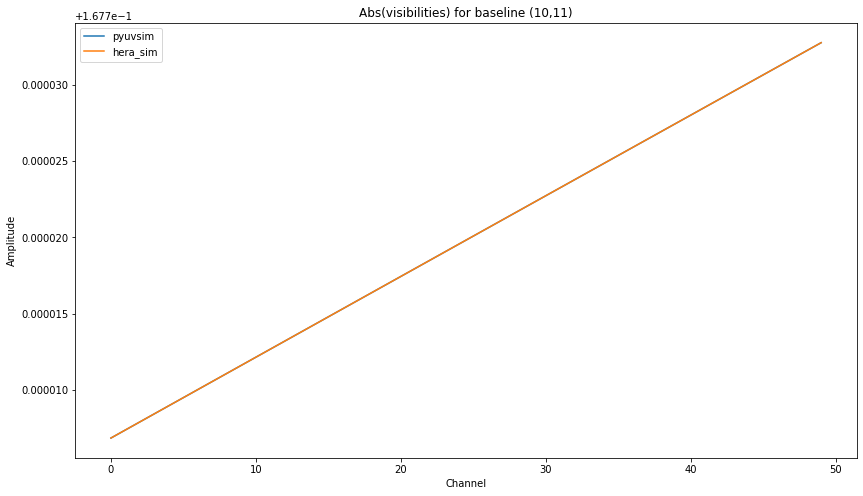

In [8]:
plt.rcParams['figure.figsize'] = [14, 8]
plt.plot(np.abs(pyuvsim_uvd.get_data(10, 11, "XX")[0]), label="pyuvsim")
plt.plot(np.abs(simulator.uvdata.get_data(10, 11, "XX")[0]), label="hera_sim")
plt.ylabel("Amplitude")
plt.xlabel("Channel")
plt.legend()
plt.title("Abs(visibilities) for baseline (10,11)")
plt.show()

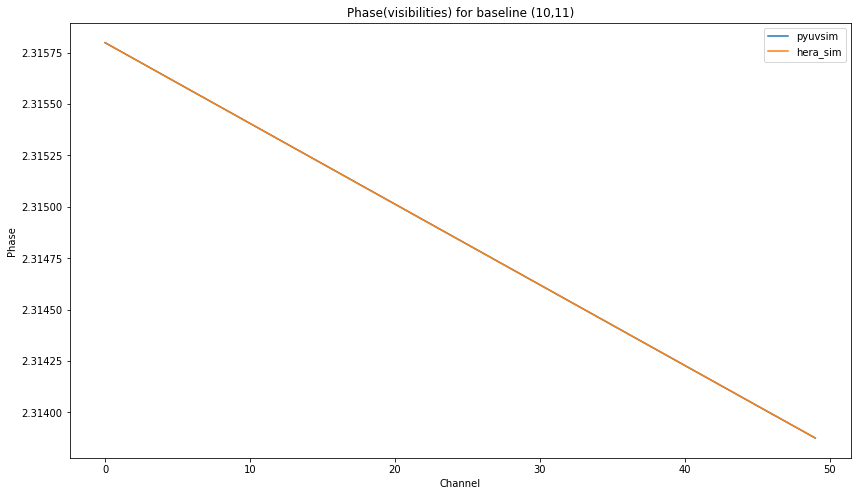

In [9]:
plt.plot(np.angle(pyuvsim_uvd.get_data(10, 11, "XX")[0]), label="pyuvsim")
plt.plot(np.angle(simulator.uvdata.get_data(10, 11, "XX")[0]), label="hera_sim")
plt.ylabel("Phase")
plt.xlabel("Channel")
plt.legend()
plt.title("Phase(visibilities) for baseline (10,11)")
plt.show()

<span style="color:red">*RESULT: The values are so close that the results can't be distinguished in the plot.*</span>

## Additional test cases



These demonstrate that the previous test case is not a "one off".

### Case 1

Different configuration. Antennas: 10, Frequencies: 120, Times: 10, Sources: 100.

Examine time 7, frequency 100, baseline (5, 7).

**Run hera_sim**

In [10]:
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=10, nfreq=120, ntime=10, nsource=100)

simulator = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        split_I = True,
        use_pixel_beams=False,
        az_za_corrections=[ "level_2", "precompute", "uvbeam_az" ],
        precision = 2
    )

start = time.time()
simulator.simulate()
herasim_time = time.time()-start

Initializing AzZaTransforms for az_za_corrections
Pre-computing az/za for all times.
Finished pre-computing. Execution time: 0.088802


**Run pyuvsim**

In [11]:
uvdata, beam, beam_dict, sky_model = telescope_config("pyuvsim", nant=10, nfreq=120, ntime=10, nsource=100)
start = time.time()
pyuvsim_uvd = uvsim.run_uvdata_uvsim(uvdata, BeamList(beam), beam_dict=beam_dict,
         catalog=simsetup.SkyModelData(sky_model))
pyuvsim_time = time.time()-start

Nbls: 55
Ntimes: 10
Nfreqs: 120
Nsrcs: 100
Tasks:  66000.0
1.00% completed. 0:00:00.851576  elapsed. 0:01:24.306033 remaining. 

2.00% completed. 0:00:01.649317  elapsed. 0:01:20.816511 remaining. 

3.00% completed. 0:00:02.450465  elapsed. 0:01:19.231708 remaining. 

4.00% completed. 0:00:03.270825  elapsed. 0:01:18.499804 remaining. 

5.00% completed. 0:00:04.076531  elapsed. 0:01:17.454083 remaining. 

6.00% completed. 0:00:04.885371  elapsed. 0:01:16.537482 remaining. 

7.00% completed. 0:00:05.689299  elapsed. 0:01:15.586406 remaining. 

8.00% completed. 0:00:06.491616  elapsed. 0:01:14.653579 remaining. 

9.00% completed. 0:00:07.310402  elapsed. 0:01:13.916288 remaining. 

10.00% completed. 0:00:08.124066  elapsed. 0:01:13.116597 remaining. 

11.00% completed. 0:00:08.930124  elapsed. 0:01:12.252824 remaining. 

12.00% completed. 0:00:09.734885  elapsed. 0:01:11.389157 remaining. 

13.00% completed. 0:00:10.616417  elapsed. 0:01:11.048332 remaining. 

14.00% completed. 0:00:11.4

In [12]:
print("COMPARISON RESULTS")
print("hera_sim time:", hera_sim_time)
print("pyuvsim time:", pyuvsim_time)
compare("pyuvsim", pyuvsim_uvd, "hera_sim", simulator.uvdata, which_time=7, which_freq=100)

COMPARISON RESULTS
hera_sim time: 0.5434167385101318
pyuvsim time: 81.43392658233643

---------------------------------- Accuracy --------------------------------------

				 pyuvsim 			 hera_sim
Auto corr ant 0 (Amplitude) 	 0.2718308990225893 		 0.27183089902258917
Cross corr ant (0,1) Amplitude 	 0.0962543457844769 		 0.09625434578447585
Cross corr ant (0,1) Phase 	 -1.9854436056211302 		 -1.9854436056211646
------------------------------------------------------------------------------------


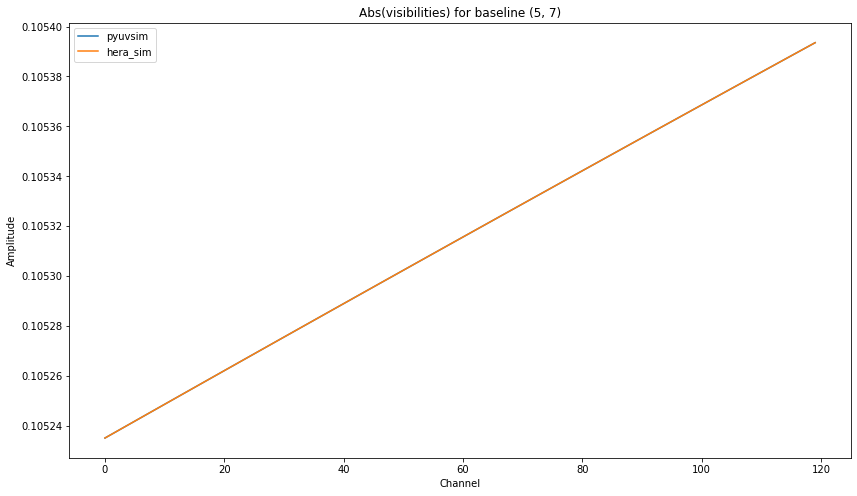

In [13]:
plt.plot(np.abs(pyuvsim_uvd.get_data(5, 7, "XX")[7]), label="pyuvsim")        # Time 7
plt.plot(np.abs(simulator.uvdata.get_data(5, 7, "XX")[7]), label="hera_sim")
plt.ylabel("Amplitude")
plt.xlabel("Channel")
plt.legend()
plt.title("Abs(visibilities) for baseline (5, 7)")
plt.show()

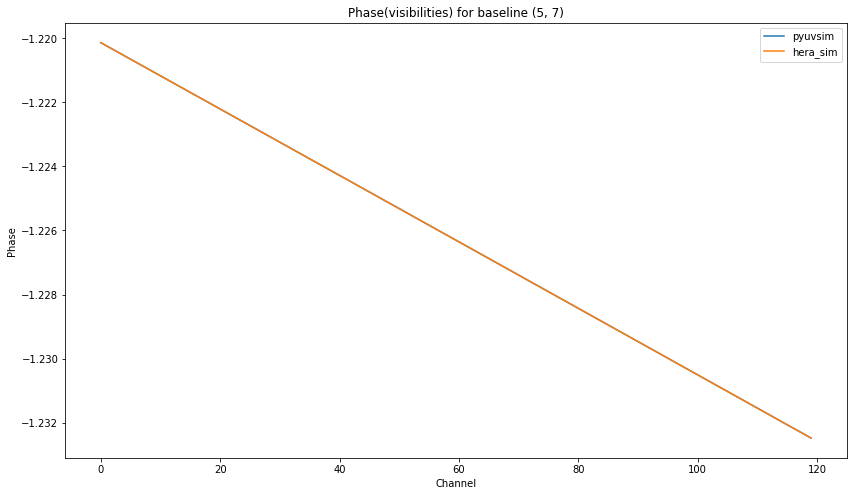

In [14]:
plt.plot(np.angle(pyuvsim_uvd.get_data(5, 7, "XX")[7]), label="pyuvsim")           # Time 7
plt.plot(np.angle(simulator.uvdata.get_data(5, 7, "XX")[7]), label="hera_sim")
plt.ylabel("Phase")
plt.xlabel("Channel")
plt.legend()
plt.title("Phase(visibilities) for baseline (5, 7)")
plt.show()

<span style="color:red">*RESULT: hera_sim still fast and accurate.*</span>

### Case 2

Antennas: 20, Frequencies: 4, Times: 100, Sources: 1000.

Examine time 40, frequency 3, baseline (4,18).

**Run hera_sim**

In [15]:
uvdata, beam, beam_dict, freqs, ra_dec, flux = telescope_config("hera_sim", nant=20, nfreq=4, ntime=100, nsource=1000)

simulator = VisCPU(
        uvdata = uvdata,
        beams = beam,
        beam_ids = list(beam_dict.values()),
        sky_freqs = freqs,
        point_source_pos = ra_dec,
        point_source_flux = flux,
        split_I = True,
        use_pixel_beams=False,
        az_za_corrections=[ "level_2", "precompute", "uvbeam_az" ],
        precision = 2
    )

start = time.time()
simulator.simulate()
herasim_time = time.time()-start

Initializing AzZaTransforms for az_za_corrections
Pre-computing az/za for all times.
Finished pre-computing. Execution time: 0.908134


**Run pyuvsim**

In [16]:
uvdata, beam, beam_dict, sky_model = telescope_config("pyuvsim", nant=20, nfreq=4, ntime=100, nsource=1000)
start = time.time()
pyuvsim_uvd = uvsim.run_uvdata_uvsim(uvdata, BeamList(beam), beam_dict=beam_dict,
         catalog=simsetup.SkyModelData(sky_model))
pyuvsim_time = time.time()-start

Nbls: 210
Ntimes: 100
Nfreqs: 4
Nsrcs: 1000
Tasks:  84000.0
1.00% completed. 0:00:01.930190  elapsed. 0:03:11.088795 remaining. 

2.00% completed. 0:00:03.814677  elapsed. 0:03:06.919173 remaining. 

3.00% completed. 0:00:05.742805  elapsed. 0:03:05.684021 remaining. 

4.00% completed. 0:00:07.622239  elapsed. 0:03:02.933733 remaining. 

5.00% completed. 0:00:09.532276  elapsed. 0:03:01.113242 remaining. 

6.00% completed. 0:00:11.444260  elapsed. 0:02:59.293409 remaining. 

7.00% completed. 0:00:13.346062  elapsed. 0:02:57.311966 remaining. 

8.00% completed. 0:00:15.239954  elapsed. 0:02:55.259465 remaining. 

9.00% completed. 0:00:17.105721  elapsed. 0:02:52.957850 remaining. 

10.00% completed. 0:00:18.978065  elapsed. 0:02:50.802589 remaining. 

11.00% completed. 0:00:20.872185  elapsed. 0:02:48.874949 remaining. 

12.00% completed. 0:00:22.772838  elapsed. 0:02:47.000813 remaining. 

13.00% completed. 0:00:24.647800  elapsed. 0:02:44.950665 remaining. 

14.00% completed. 0:00:26.

In [17]:
print("COMPARISON RESULTS")
print("hera_sim time:", hera_sim_time)
print("pyuvsim time:", pyuvsim_time)
compare("pyuvsim", pyuvsim_uvd, "hera_sim", simulator.uvdata, which_time=40, which_freq=3)

COMPARISON RESULTS
hera_sim time: 0.5434167385101318
pyuvsim time: 189.216698884964

---------------------------------- Accuracy --------------------------------------

				 pyuvsim 			 hera_sim
Auto corr ant 0 (Amplitude) 	 1.5166072231983834 		 1.516607223198383
Cross corr ant (0,1) Amplitude 	 0.035461946104810134 		 0.035461946104806887
Cross corr ant (0,1) Phase 	 2.4465711904108223 		 2.4465711904108005
------------------------------------------------------------------------------------


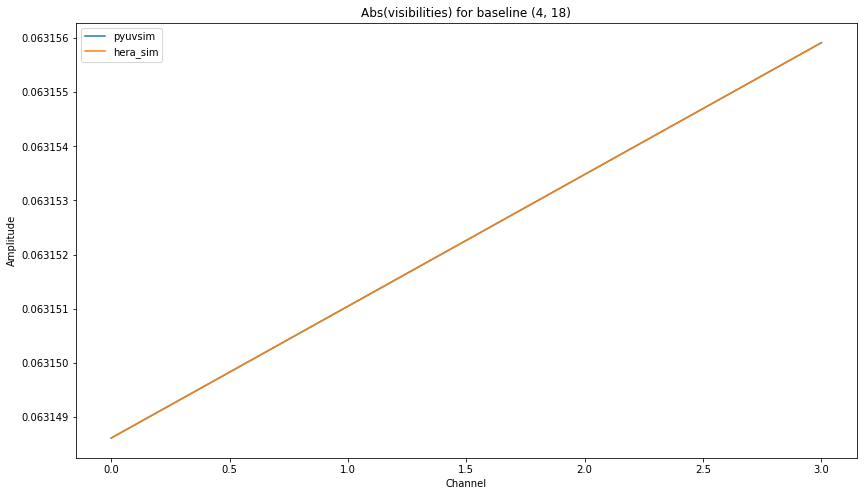

In [18]:
plt.plot(np.abs(pyuvsim_uvd.get_data(4, 18, "XX")[40]), label="pyuvsim")        # Time 40
plt.plot(np.abs(simulator.uvdata.get_data(4, 18, "XX")[40]), label="hera_sim")
plt.ylabel("Amplitude")
plt.xlabel("Channel")
plt.legend()
plt.title("Abs(visibilities) for baseline (4, 18)")
plt.show()

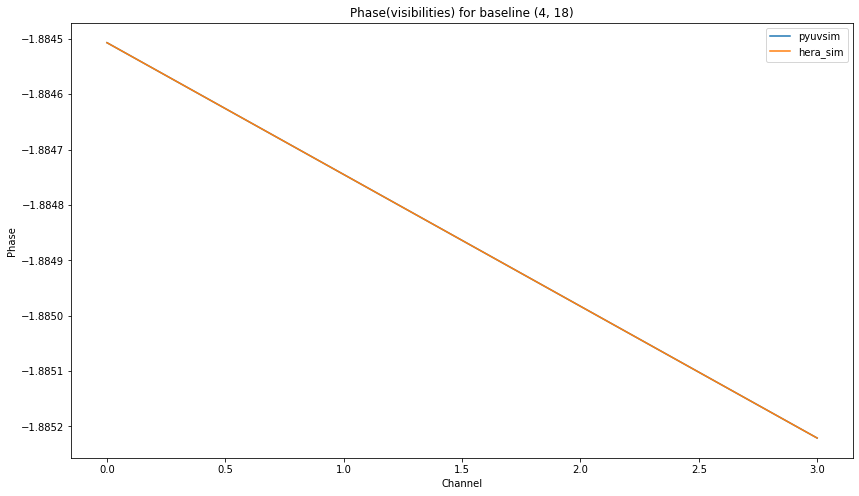

In [19]:
plt.plot(np.angle(pyuvsim_uvd.get_data(4, 18, "XX")[40]), label="pyuvsim")           # Time 40
plt.plot(np.angle(simulator.uvdata.get_data(4, 18, "XX")[40]), label="hera_sim")
plt.ylabel("Phase")
plt.xlabel("Channel")
plt.legend()
plt.title("Phase(visibilities) for baseline (4, 18)")
plt.show()

<span style="color:red">*RESULT: hera_sim still fast and accurate.*</span>

# Performance of enhanced hera_sim vs. pyuvsim at large scales


Each parameter (antennas/frequencies/times/sources) is scaled up while holding the others constant.

Method:

- Start with these parameters: Antennas=10, Frequencies=10, Times=10, Sources=10
- Pick one of those parameters. Increase its value and measure the simulation time and memory use. For both hera_sim and pyuvsim.
- Plot the results.

In pseudo-code:

```
# Increase antennas
num_antennas = num_frequencies = num_times = num_sources = 10
for value in 10, 20, 30 ....
    num_antennas = value    
    simulation_time, memory_uasge = simulate(num_antennas, num_frequencies, num_times, num_sources)
    plot(num_antennas, simulation_time, memory_ussge)
    
# Increase frequencies
num_antennas = num_frequencies = num_times = num_sources = 10
for value in 10, 20, 30 ....
    num_frequencies = value   
    simulation_time, memory_uasge = simulate(num_antennas, num_frequencies, num_times, num_sources)
    plot(num_frequencies, simulation_time, memory_ussge)
    
ETC.

```

For each parameter there will be two plots:
- Simulation Time versus parameter value 
- Memory usage versus parameter value

The number of antennas will be plotted as the number of *baselines*. 

Simulations were run on ILIFU in South Africa. No MPI is used, these are all serial runs. The maximum allowed run time was 72 hours. The maximum allowed memory was 232GB. Some pyuvsim runs failed to complete because of these limits. That will be seen in the plots, where the pyuvsim plot does extend over the complete x-axis range. These simulations are not done in the notebook because they take a long time. I only show the results.



### Increase number of baselines

**Simulation time**
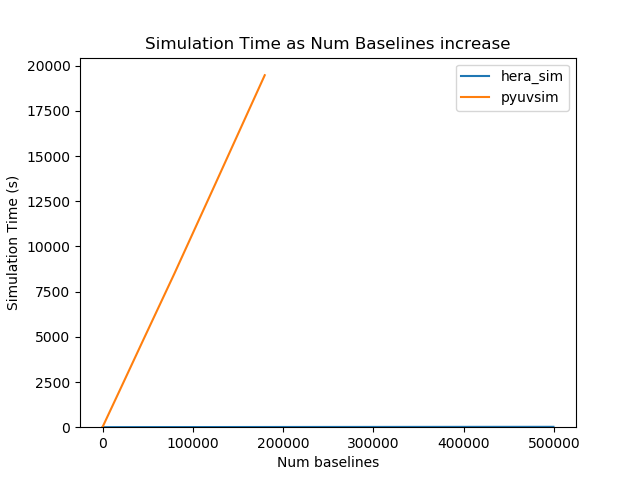

As hera_sim is not visibile in this plot, I show the same plot but clipped on the y-axis:
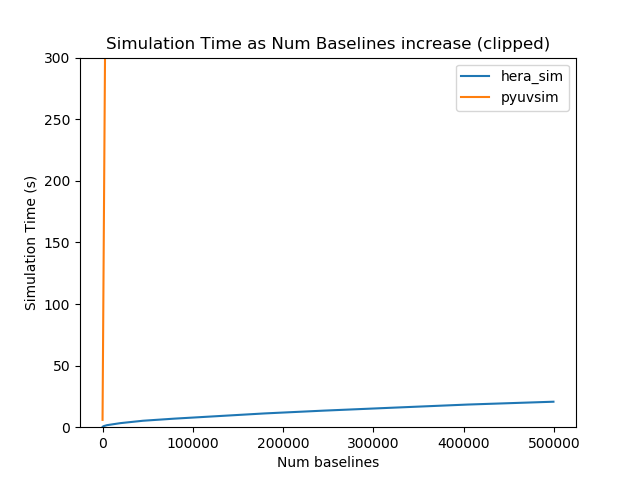

**Memory usage**

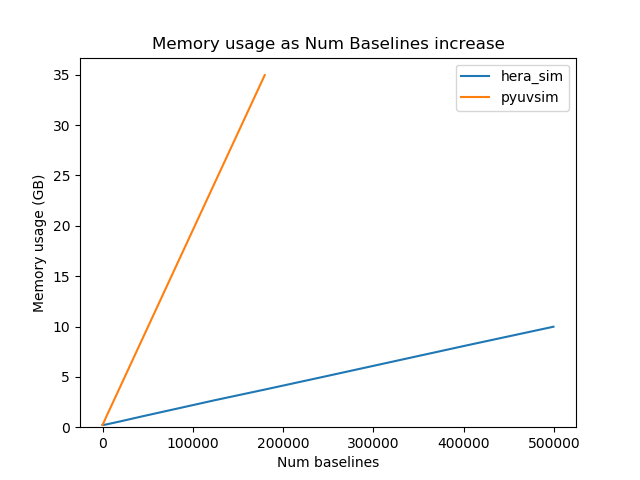
### Increase number of frequencies

**Simulation time**
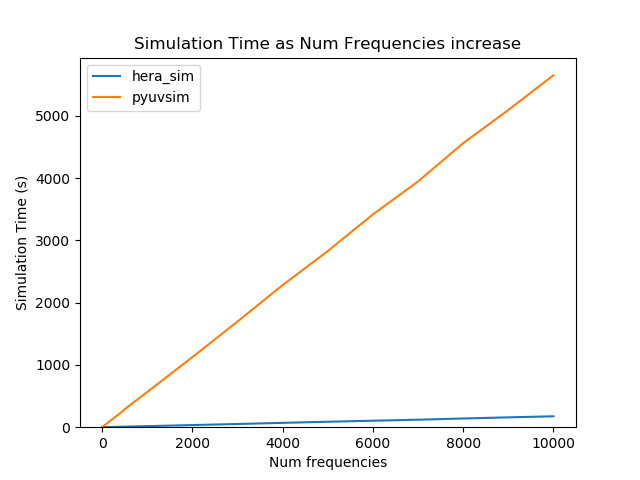

**Memory usage**
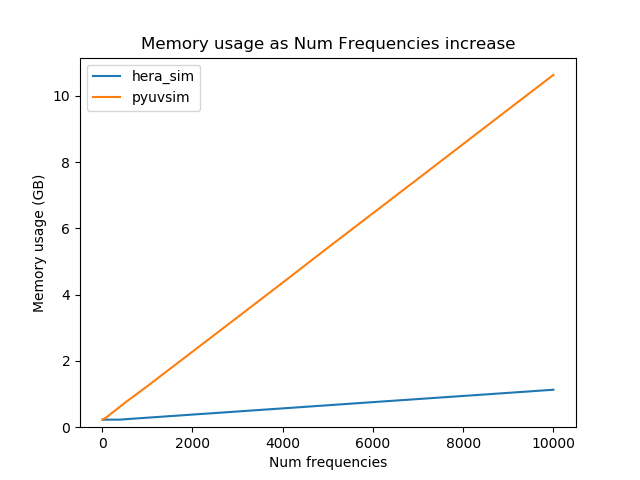

### Increase number of times

**Simulation time**
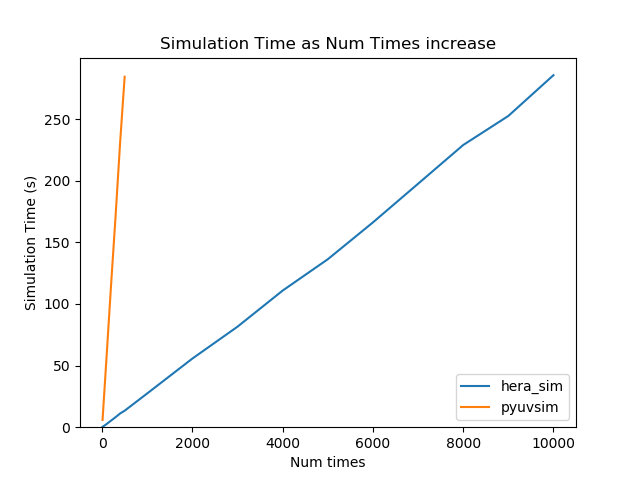
**Memory usage**
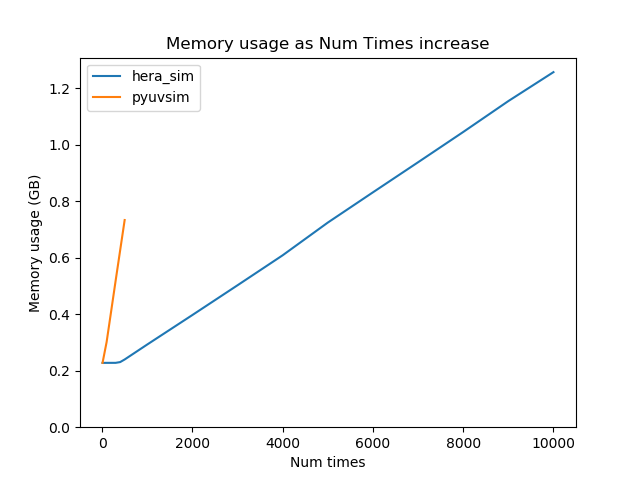

### Increase number of sources

**Simulation time**
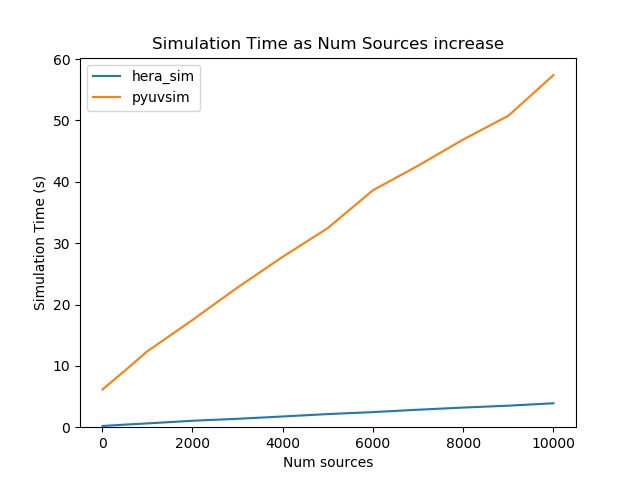

**Memory usage**
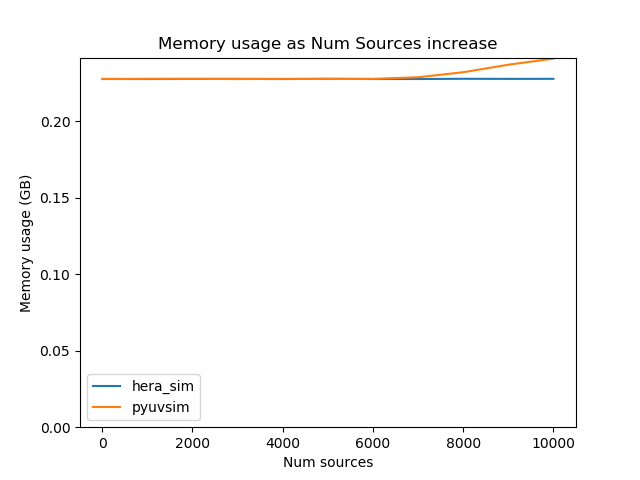


